# E-Commerce EDA & Customer Segmentation

### About the dataset

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Research Questions

- What is the general sales trend?
- What are the best selling products?
- What countries are the most active?
- How can we group our customers to effectively target each customer segment?

### Variables in dataset

*InvoiceNo*: A 6-digit integral number assigned to each transaction. Categorical Variable. 

*StockCode*: A 5-digit integral number uniquely assigned to identify each product item. Letters assigned at the back of Stockcode indicate variations of the same item. Categorical Variable.

*Description*: Textual description of product items. Categorical Variable.

*Quantity*: The number of units of item purchased per transaction. Numerical Variable. 

*InvoiceDate*: Date and Time of issue of Invoice. Categorical Variable.

*UnitPrice*: Price of one unit of item. Numerical Variable.

*CustomerID*: A 5-digit integral number assigned to identify each customer. Numeric Variable.

*Country*: Name of country in which customer resides. Categorical Variable.

# Imports

In [1]:
#Import Relevant libraries 
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Import Dataset
dataset = pd.read_csv('E-Commerce.csv', encoding='ISO-8859-1') 
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom


In [4]:
#Print out variable information in Dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
print(("Dimensions of DataFrame: "), dataset.shape)

Dimensions of DataFrame:  (541909, 8)


# Cleaning Data

In [6]:
#Create a copy of the dataset 
EcommData = dataset.copy()

In [7]:
#Check for duplicate entries in dataset
EcommData.duplicated().sum()

5268

In [8]:
#Drop duplicates 
EcommData.drop_duplicates(inplace = True)

#Print sum of duplicates in updated dataset
EcommData.duplicated().sum()

0

In [9]:
#Check missing values in data 
EcommData.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [10]:
#Drop rows with missing values
EcommData.dropna(axis = 0, subset = ['Description','CustomerID'], inplace = True)

#Reset index to create continuous sequence of integers beginning from 1
EcommData.reset_index(drop = True, inplace = True)

#Print out NULL value sum 
EcommData.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
#Change Description from Uppercase to Lowercase for greater readability
EcommData['Description'] = EcommData.Description.str.lower().str.title()

#Create column for Total Price 
EcommData['TotalPrice'] = EcommData['UnitPrice'] * EcommData['Quantity']

#Remove negative Quantity and UnitPrice values 
EcommData = EcommData[(EcommData['Quantity'] > 0) & (EcommData['UnitPrice'] > 0)]

In [12]:
print(("Dimensions of Cleaned DataFrame: "), EcommData.shape)

Dimensions of Cleaned DataFrame:  (392692, 9)


In [13]:
#Change 'InvoiceDate' to datetime data type
EcommData['InvoiceDate'] = pd.to_datetime(EcommData['InvoiceDate'])

#Print data type of variables
EcommData.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalPrice            float64
dtype: object

In [14]:
EcommData.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,White Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,White Metal Lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,Cream Cupid Hearts Coat Hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,Red Woolly Hottie White Heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Exploratory Data Analysis

In [15]:
EcommData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 401603
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


### Sales over Time

In [16]:
#Create copy of data for EDA 
data = EcommData.copy()

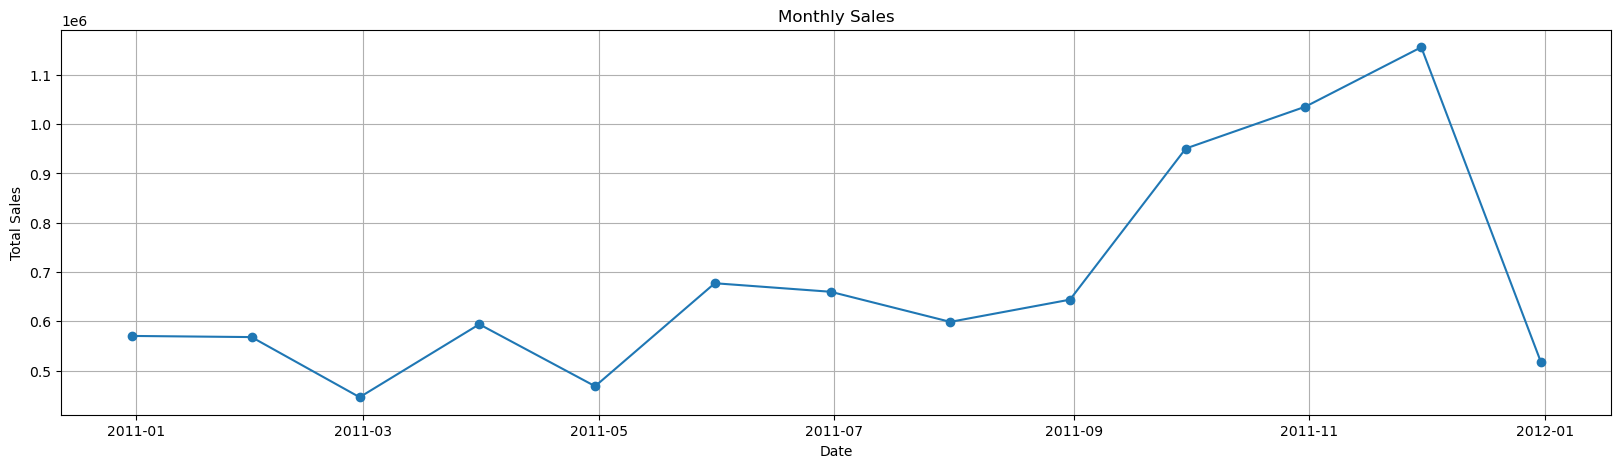

In [17]:
#Set InvoiceDate column as the index
data.set_index('InvoiceDate', inplace=True)

#Resample to MONTHLY frequency and sum the UnitPrices 
monthly_sales = data['TotalPrice'].resample('M').sum()

#Plot the Time series 
plt.figure(figsize=(20,5))
plt.plot(monthly_sales, marker='o')
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)

### Price Distribution of Products

Text(0.5, 1.0, 'Boxplot of Product Unit Prices')

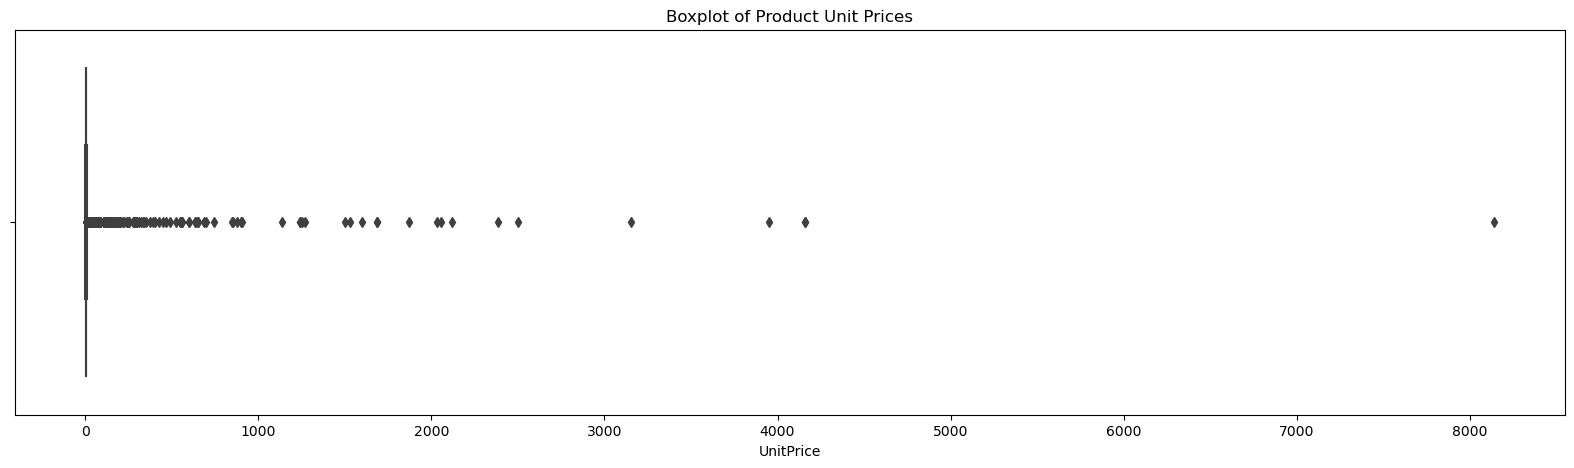

In [18]:
#Boxplot of Product Prices 
plt.figure(figsize=(20, 5))
sb.boxplot(x=(data['UnitPrice']))
plt.title('Boxplot of Product Unit Prices')

In [19]:
data['UnitPrice'].describe()

count    392692.000000
mean          3.125914
std          22.241836
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

Most Products have a low price range, with median 1.95. However, there exists outliers with prices up to 8142.75.

### Top Selling Products  

Text(0.5, 0, 'Total Sales')

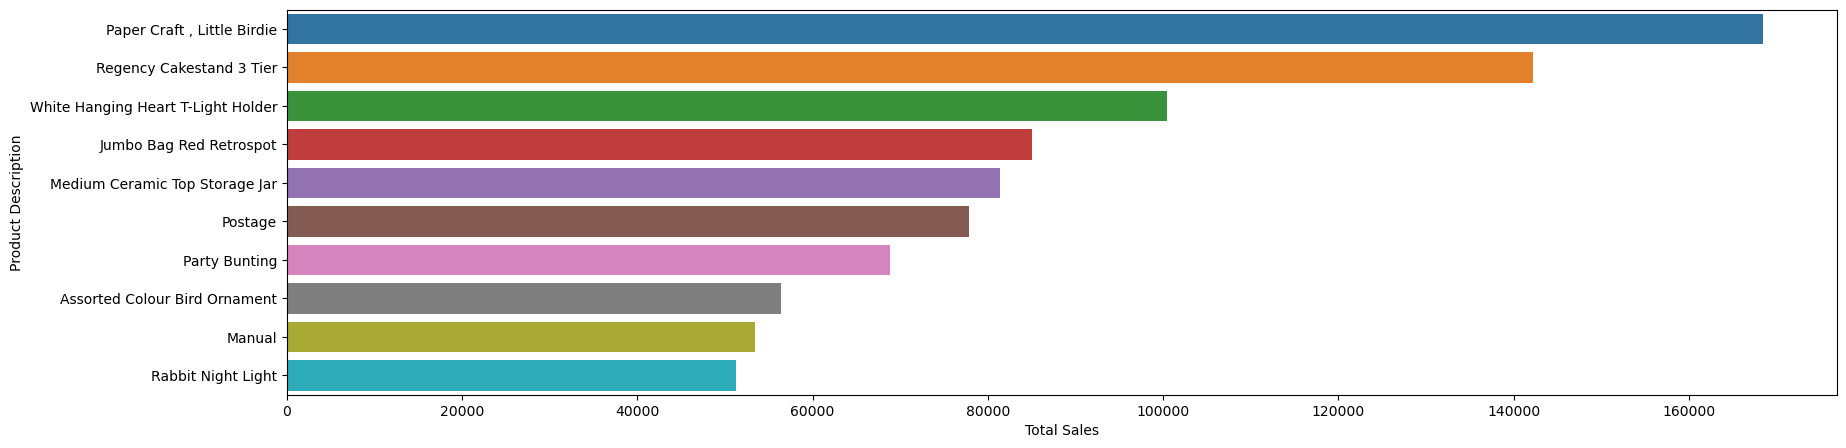

In [20]:
#Top Selling Products 
top_products = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize=(20,5))
sb.barplot(x=top_products.values, y=top_products.index)
plt.ylabel('Product Description')
plt.xlabel('Total Sales')

The barplot shows the most popular products. Marketing efforts should be focused on these items to maximise sales. 

### Orders across different Countries

In [21]:
#Printing out total unique countries orders origin from
print("Number of Unique Countries: ", len(data['Country'].unique()))
print('\t')

#Printing out individual country names orders origin from
unique_countries = data['Country'].unique()
print(unique_countries)

Number of Unique Countries:  37
	
['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Israel' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']


In [22]:
#Number of orders originating from each of the identified countries
data['Country'].value_counts()

Country
United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


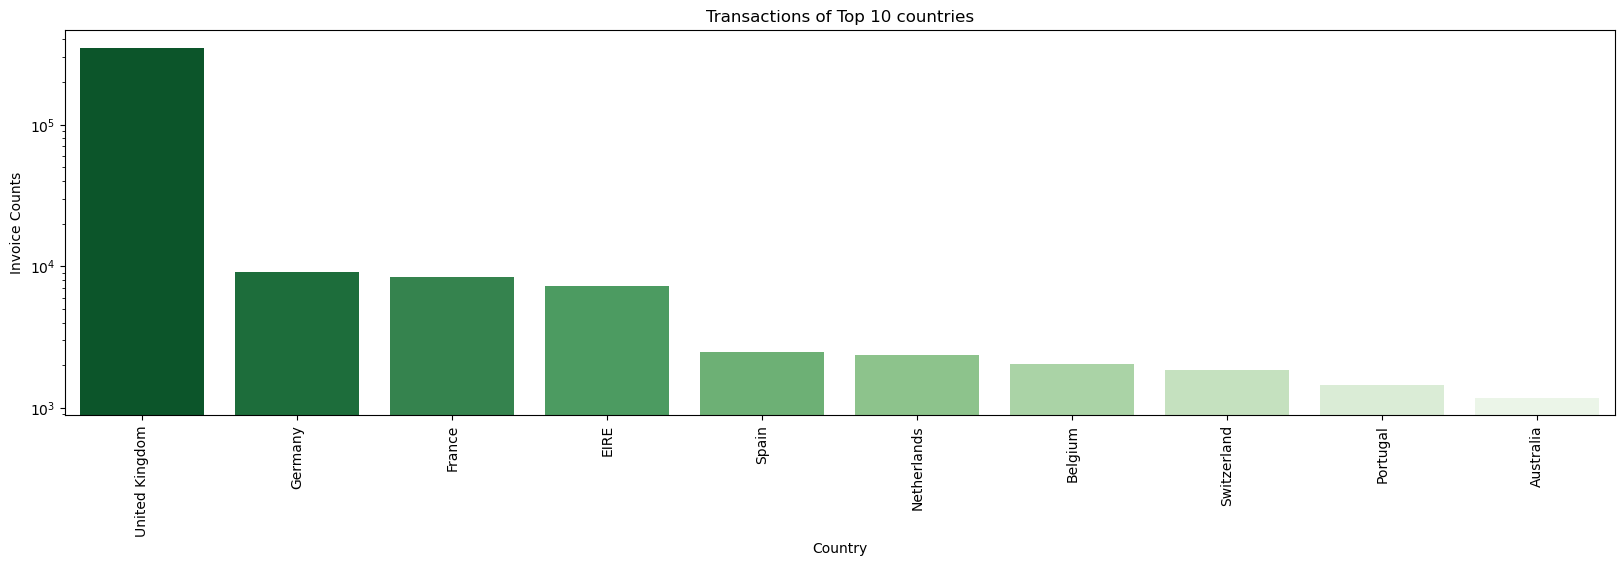

In [23]:
#Barplot of the total transactions of top 10 countries 
country_counts = data['Country'].value_counts().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize=(20, 5))
sb.barplot(x=country_counts.index, y=country_counts.values, palette="Greens_r")
plt.ylabel('Invoice Counts')
plt.title('Transactions of Top 10 countries')
plt.xticks(rotation=90)
plt.yscale('log')

Text(0.5, 1.0, 'Sales of Top 10 Countries')

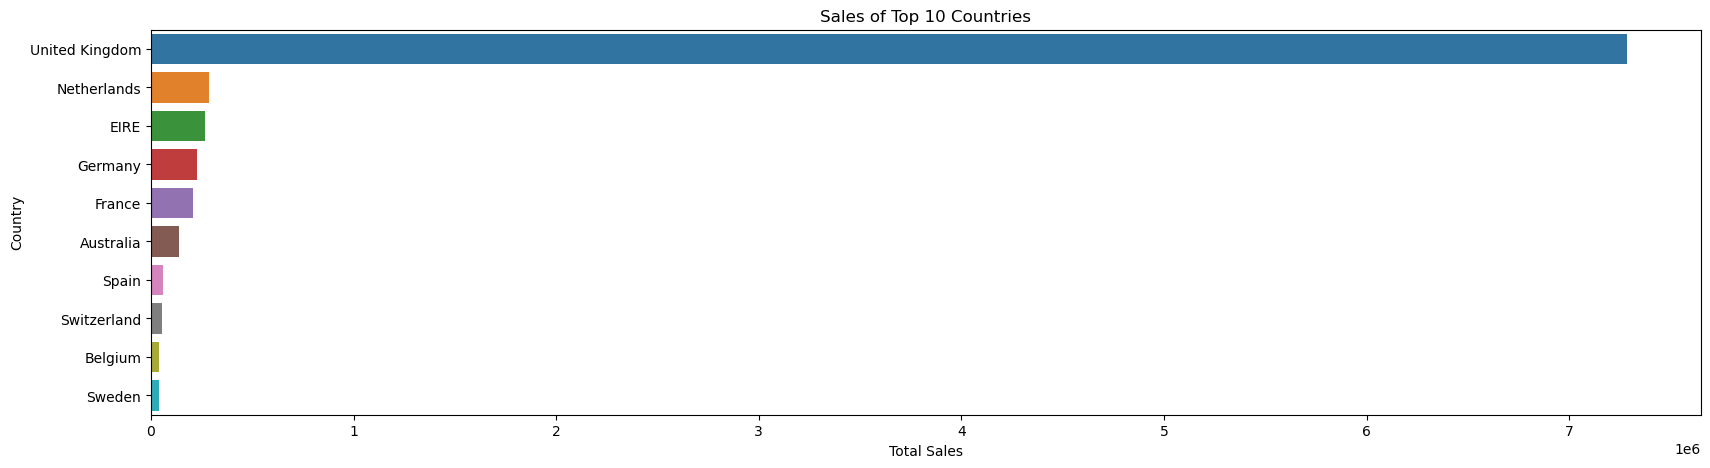

In [24]:
#Barplot of the sales of top 10 countries 
country_sales = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).iloc[0:10]
plt.figure(figsize=(20, 5))
sb.barplot(x=country_sales.values, y=country_sales.index)
plt.ylabel('Country')
plt.xlabel('Total Sales')
plt.title('Sales of Top 10 Countries')

From the barplots, UK records the highest number of transactions and sales. This is not unexpected as it is a UK-based and registered online retail. Other top-performing countries include mostly countries in Europe such as Netherlands, Ireland, Germany and France. 

### Summary of Findings 

In [25]:
print(f"Total Sales: {data['TotalPrice'].sum():.2f}")
print(f"Total Transactions: {len(data)}")
print(f"Top Selling Product: {top_products.index[0]}")
print(f"Top Country: {country_sales.index[0]}")

Total Sales: 8887208.89
Total Transactions: 392692
Top Selling Product: Paper Craft , Little Birdie
Top Country: United Kingdom


# Customer Segmentation by KMeans Clustering

In [26]:
#Define today date to determine recency
today_date = dt.datetime(2012, 2, 1)

#Prepare Customer Data for Clustering 
customer_data = EcommData.groupby('CustomerID').agg({
    'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

#Rename Columns in customer_data
customer_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

#Print Customer Data
customer_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,378,1,77183.60
1,12347.0,55,7,4310.00
2,12348.0,128,4,1797.24
3,12349.0,71,1,1757.55
4,12350.0,363,1,334.40


In [27]:
#Select columns for clustering 
rfm_data = customer_data[['Recency', 'Frequency', 'Monetary']]

#Scale data 
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)
rfm_scaled = pd.DataFrame(rfm_scaled, columns = ['Recency', 'Frequency', 'Monetary'])

#Add back CustomerID into Scaled dataframe 
rfm_scaled['CustomerID'] = customer_data['CustomerID']

#Set Index as CustomerID
rfm_scaled = rfm_scaled.set_index('CustomerID', drop=True)

#Print data
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.329388,-0.425097,8.363010
12347.0,-0.900588,0.354417,0.251699
12348.0,-0.170593,-0.035340,-0.027988
12349.0,-0.740589,-0.425097,-0.032406
12350.0,2.179389,-0.425097,-0.190812


In [28]:
#Create List of numbers 2 to 10
num_clusters = [i for i in range(2, 11)]

#Create function to fit KMeans models for different values of k and Calculate Inertia
def kmeans_inertia(num_clusters, x_vals):
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    return inertia

In [29]:
#Calculate inertia for k=2-10
inertia = kmeans_inertia(num_clusters, rfm_scaled)
inertia

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

[9014.520269915847,
 5441.672963636598,
 4096.574324272689,
 3120.0380995444516,
 2503.3169258773987,
 2023.8516779576048,
 1715.9644477444713,
 1466.8200119135054,
 1284.1472833607904]

Text(0.5, 1.0, 'Elbow Plot of Clusters')

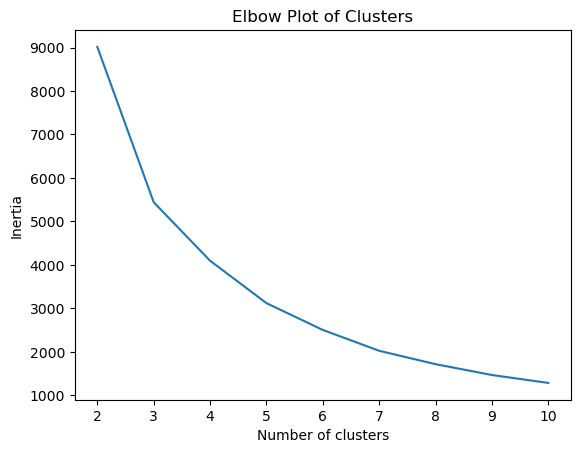

In [30]:
#Create Elbow Plot 
plot = sb.lineplot(x=num_clusters, y=inertia)
plot.set_xlabel('Number of clusters')
plot.set_ylabel('Inertia')
plot.set_title('Elbow Plot of Clusters')

From the Elbow Plot, we will select k=3 as the number of clusters.

In [31]:
#Apply KMeans for k=3 to find centroids 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=list(rfm_scaled))
centroids_df

,Recency,Frequency,Monetary
0,-0.512290,0.052723,-0.021952
1,-0.865973,8.074597,9.324975
2,1.540617,-0.349559,-0.157917


In [32]:
#Create DataFrame of the labels of points
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))

#Convert labels column to categorical 
df_labels['labels'] = df_labels['labels'].astype('category')

#Create Copy of rfm_scaled DataFrame
df_plot = rfm_scaled.copy()

#Add labels column to rfm_scaled
df_plot['labels'] = df_labels['labels'].values

#Print DataFrame
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.329388,-0.425097,8.363010
12347.0,-0.900588,0.354417,0.251699
12348.0,-0.170593,-0.035340,-0.027988
12349.0,-0.740589,-0.425097,-0.032406
12350.0,2.179389,-0.425097,-0.190812


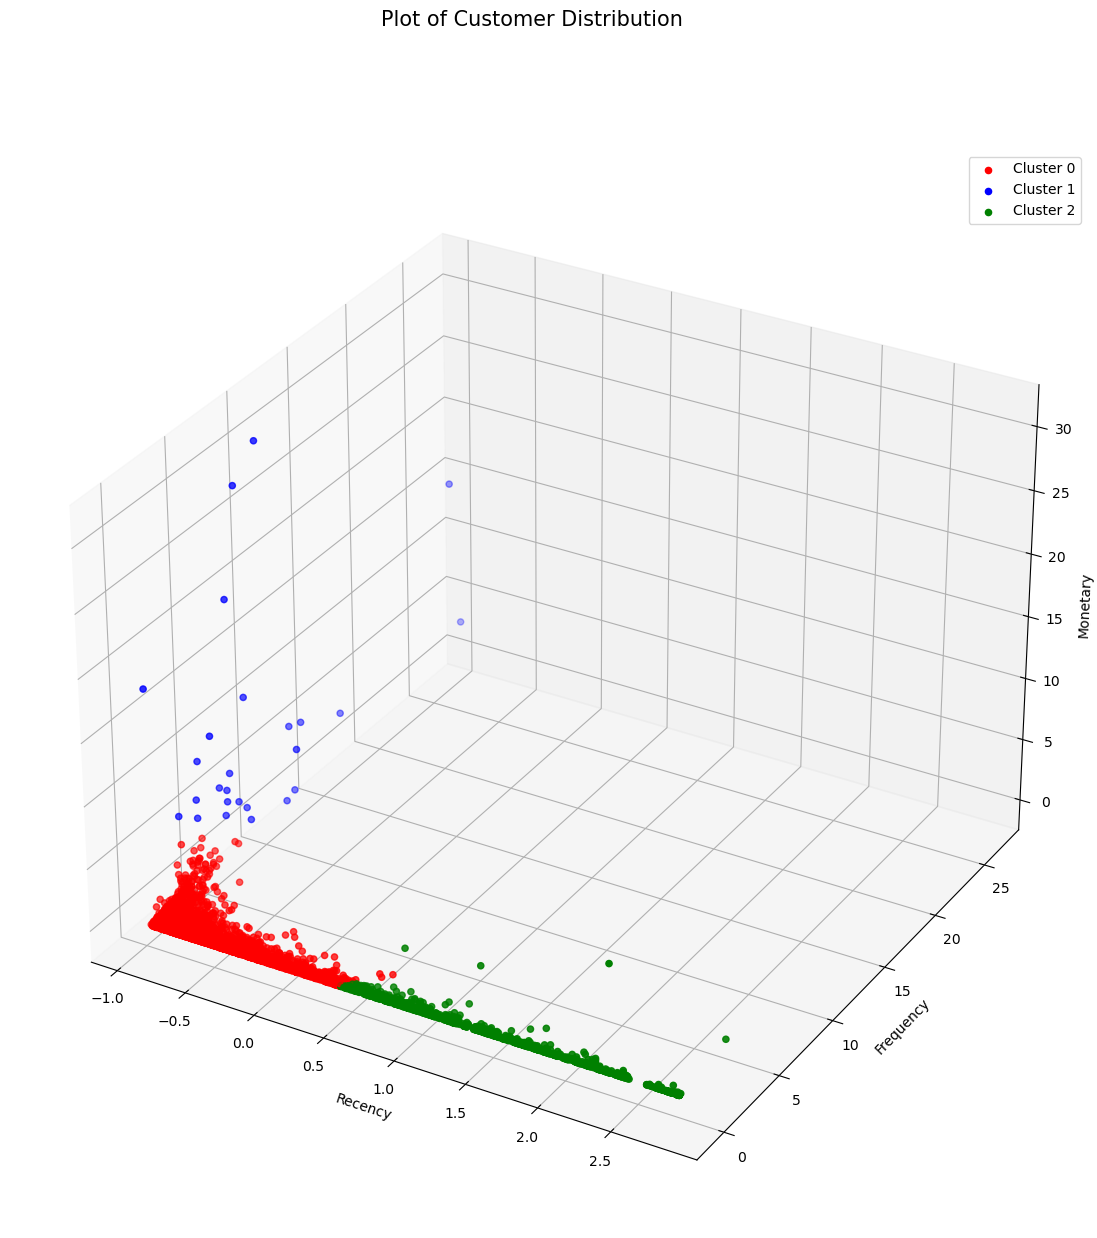

In [33]:
#3D Plot of Customer Distribution
colors = np.array(['red', 'blue', 'green'])
fig = plt.figure(figsize=(14, 14)).suptitle('Plot of Customer Distribution', fontsize=15)
ax = plt.axes(projection='3d')
ax.scatter3D(df_plot['Recency'], df_plot['Frequency'], df_plot['Monetary'], marker='o', c=colors[df_plot['labels'].tolist()])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2']
for i in range(len(labels)):
    ax.scatter([],[],[],c=colors[i],label=labels[i])
plt.legend()

In [34]:
#Calculate the count of each cluster label
cluster_percentage = df_plot['labels'].value_counts(normalize=True)*100
print(cluster_percentage)

labels
0    74.343015
2    25.057630
1     0.599355
Name: proportion, dtype: float64


In [35]:
#Evaluating KMeans Model 
kmeans3_sil_score = silhouette_score(rfm_scaled, kmeans.labels_)
kmeans3_sil_score

0.5937570862143289

The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters, ranging from -1 to 1. Our model's silhouette score of 0.593757 suggests clusters are fairly well defined. 

### Customer Segmentation 

From the KMeans Clustering, Customers can be segmented into 3 groups. 

**Cluster 0: Regular Customers** 
These are customers that buy products more regularly on the website. Implement loyalty programs that reward regular purchases. Offer points for each purchase that can be redeemed for discounts or exclusive perks. 

**Cluster 1: Exceptional Customers** - These are customers that buy at the highest frequency, and spend the most money. Reward them with exclusive offers and premium services such as expedited shipping to retain these customers. 

**Cluster 2: Recent Customers** - These are customers that have been active recently. Welcome Offers and Retention Strategies can be targetted towards these customers to encourage them to become regular purchasers.

# Conclusion

1. Monthly Sales have a general increasing trend in 2011. However, there is a significant outlier in January 2012, which is unexpected given that the dataset only contains data from December 1, 2010, to September 12, 2011. 
<br>

2. The top-selling product is 'Paper Craft, Little Birdie'. More Marketing Efforts can be placed on promoting this product to boost sales.
<br>

3. The majority of sales originate from European countries, with the United Kingdom contributing the largest share. 
<br>

4. Customers can be segmented into three distinct groups using the KMeans clustering algorithm, based on their recency, frequency, and monetary metrics. Marketing efforts can be targetted according to the different groups. 